<h1>Dependencies

In [ ]:
!pip install stable-baselines3[extra]

In [ ]:
!pip install gym

In [ ]:
!pip show gym

In [1]:
import sys
sys.path.append('c:\\users\\hp\\desktop\\projectpeptide\\summer_internship_2023\\projectpeptide\\lib\\site-packages')

In [2]:
import gym 
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import numpy as np
import random

import os

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy

from rdkit import Chem
from rdkit.Chem import Crippen

<h1> Types of Spaces

In [ ]:
Discrete(3).sample()

In [ ]:
Box(0,1,shape=(3,3)).sample()

In [ ]:
Tuple((Discrete(2), Box(0,100, shape=(1,)))).sample()

In [ ]:
Dict({'height':Discrete(2), "speed":Box(0,100, shape=(1,))}).sample()

In [ ]:
MultiBinary(4).sample()

In [ ]:
MultiDiscrete([5,2,2]).sample()

<h1> Building an Environment

In [3]:
len_peptide = 5

In [11]:
#Reward as logP only

# Function to convert amino acid indices to a tripeptide sequence
def indices_to_peptide(indices):
    amino_acids = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']
    peptide_sequence = '-'.join([amino_acids[i] for i in indices])
    return peptide_sequence

# Function to calculate logP for a tripeptide
def calculate_logP(peptide_sequence):
    # Create an RDKit molecule object
    mol = Chem.MolFromSequence(peptide_sequence)

    # Check if the molecule is valid
    if mol is not None:
        # Calculate the logP value using Crippen's method
        logP = Crippen.MolLogP(mol)
        return logP
    else:
        # Return a placeholder value (you may want to handle invalid sequences differently)
        return -1000000000.0

In [14]:
peptide = MultiDiscrete([20] * len_peptide).sample()

# Convert indices to a tripeptide sequence
sequence = indices_to_peptide(peptide)
hydrophobicity = calculate_logP(sequence)

print('Protein chain as interger: {}\nProtein chain as string: {}\nHydrophobicity value for protein chain: {}'.format(peptide, sequence, hydrophobicity))

Protein chain as interger: [ 5  2 17 11  5]
Protein chain as string: GLN-ASN-TRP-LYS-GLN
Hydrophobicity value for protein chain: -10.684129999999941


In [29]:
class peptideEnv(Env):
    
    def __init__(self):
        
        # Actions taken are placing the randomized amino acid at the randomized position of the peptide 
        self.action_space = MultiDiscrete([20, len_peptide])
        
        # all the peptides sequence possible
        self.observation_space = MultiDiscrete([20] * len_peptide)
        
        # Set start as a randomized peptide
        self.state = MultiDiscrete([20] * len_peptide).sample()
        self.critical_logP = -1000000000.0
        
        self.numAction = 100
        
        
        
    def step(self, action):
        
        # Extract amino acid and position from the action
        amino_acid = action // len_peptide
        position = action % len_peptide

        # Update the state based on the action
        self.state[position] = amino_acid
        self.numAction -=1
        
        
        
        # Convert indices to a peptide sequence and calculate logP 
        # for the peptide
        sequence = indices_to_peptide(self.state)
        logP_value = calculate_logP(sequence)
        
        
        # Calculate reward
        if logP_value > self.critical_logP: 
            reward = 1 
            self.critical_logP = logP_value
        elif logP_value == self.critical_logP:
            reward = 0
        else:
            reward = -1 
        
        # Check if shower is done
        if self.numAction <= 0: 
            done = True
        else:
            done = False
        
        info = {}
        
        # Return step information
        return self.state, reward, done, info

    
    
    def render(self):
        # Implement viz
        pass
    
    
    
    def reset(self):
        # Reset the peptide to a new randomized state
        self.state = MultiDiscrete([20] * len_peptide).sample()

        # Reset critical_logP at the beginning of each episode
        self.critical_logP = -1000000000.0
        self.numAction = 100
        return self.state

In [30]:
env = peptideEnv()

In [31]:
env.observation_space.sample()

array([ 8,  0, 16,  9, 13], dtype=int64)

In [32]:
env.reset()

array([ 2,  2, 14,  0, 15], dtype=int64)

In [33]:
# from stable_baselines3.common.env_checker import check_env
# check_env(env, warn=True)

<h1> Test Environment

In [19]:
episodes = 5
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    
    while not done:
        env.render()
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score+=reward
    print('Episode:{} Score:{}'.format(episode, score))
env.close()

Episode:1 Score:-80
Episode:2 Score:-74
Episode:3 Score:-87
Episode:4 Score:-80
Episode:5 Score:-85


In [20]:
env.close()

<h1> Train Model

In [34]:
log_path = os.path.join('Training', 'Logs')

In [35]:
del model

In [36]:
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_path)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [37]:
model.learn(total_timesteps= 500000, log_interval= 10)

Logging to Training\Logs\PPO_1
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 100        |
|    ep_rew_mean          | -71.2      |
| time/                   |            |
|    fps                  | 214        |
|    iterations           | 10         |
|    time_elapsed         | 95         |
|    total_timesteps      | 20480      |
| train/                  |            |
|    approx_kl            | 0.00809248 |
|    clip_fraction        | 0.0843     |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.46      |
|    explained_variance   | -4.66e-05  |
|    learning_rate        | 0.0003     |
|    loss                 | 66.1       |
|    n_updates            | 90         |
|    policy_gradient_loss | -0.0178    |
|    value_loss           | 98.9       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean        

<h1> Save Model

In [39]:
model.save('PPO')

<h1> Mean Reward

In [40]:
# Assuming 'model' and 'env' are already defined
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10, render=True)

print(f"Mean Reward: {mean_reward}, Std Reward: {std_reward}")

c:\users\hp\desktop\projectpeptide\summer_internship_2023\projectpeptide\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
c:\users\hp\desktop\projectpeptide\summer_internship_2023\projectpeptide\lib\site-packages\stable_baselines3\common\vec_env\base_vec_env.py:243: UserWarning: You tried to call render() but no `render_mode` was passed to the env constructor.
  warnings.warn("You tried to call render() but no `render_mode` was passed to the env constructor.")


Mean Reward: 5.0, Std Reward: 1.5491933384829668


<h1> Graphs

In [41]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

In [43]:
logPath = os.path.join('Training', 'Logs', 'PPO_1')

# Load logs
event_acc = EventAccumulator(logPath)
event_acc.Reload()

In [44]:
# List all scalar tags in the event file
scalar_tags = event_acc.Tags()['scalars']
print(scalar_tags)

['rollout/ep_len_mean', 'rollout/ep_rew_mean', 'time/fps', 'train/approx_kl', 'train/clip_fraction', 'train/clip_range', 'train/entropy_loss', 'train/explained_variance', 'train/learning_rate', 'train/loss', 'train/policy_gradient_loss', 'train/value_loss']


In [45]:
# Load logs
event_acc = EventAccumulator(logPath)
event_acc.Reload()

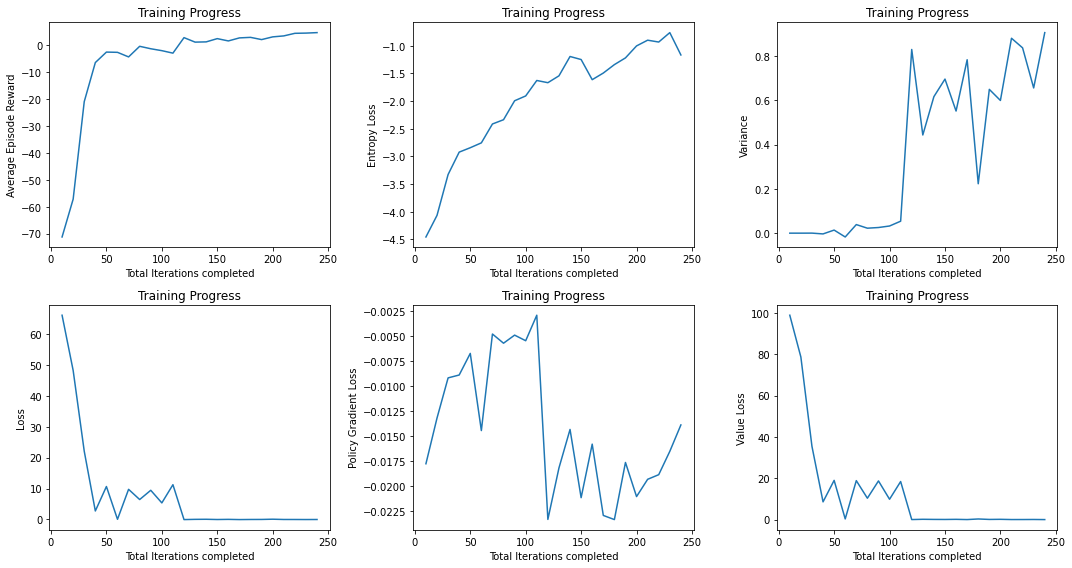

In [47]:
# Extract relevant information
timesteps = np.arange(10,250, 10)

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

# Plot in the first subplot
rewards = [scalars.value for scalars in event_acc.Scalars('rollout/ep_rew_mean')]
axes[0, 0].plot(timesteps, rewards)
axes[0, 0].set_xlabel('Total Iterations completed')
axes[0, 0].set_ylabel('Average Episode Reward')
axes[0, 0].set_title('Training Progress')

# Plot in the first subplot
rewards = [scalars.value for scalars in event_acc.Scalars('train/entropy_loss')]
axes[0, 1].plot(timesteps, rewards)
axes[0, 1].set_xlabel('Total Iterations completed')
axes[0, 1].set_ylabel('Entropy Loss')
axes[0, 1].set_title('Training Progress')

# Plot in the first subplot
rewards = [scalars.value for scalars in event_acc.Scalars('train/explained_variance')]
axes[0, 2].plot(timesteps, rewards)
axes[0, 2].set_xlabel('Total Iterations completed')
axes[0, 2].set_ylabel('Variance')
axes[0, 2].set_title('Training Progress')

# Plot in the first subplot
rewards = [scalars.value for scalars in event_acc.Scalars('train/loss')]
axes[1, 0].plot(timesteps, rewards)
axes[1, 0].set_xlabel('Total Iterations completed')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Training Progress')

# Plot in the first subplot
rewards = [scalars.value for scalars in event_acc.Scalars('train/policy_gradient_loss')]
axes[1, 1].plot(timesteps, rewards)
axes[1, 1].set_xlabel('Total Iterations completed')
axes[1, 1].set_ylabel('Policy Gradient Loss')
axes[1, 1].set_title('Training Progress')

# Plot in the first subplot
rewards = [scalars.value for scalars in event_acc.Scalars('train/value_loss')]
axes[1, 2].plot(timesteps, rewards)
axes[1, 2].set_xlabel('Total Iterations completed')
axes[1, 2].set_ylabel('Value Loss')
axes[1, 2].set_title('Training Progress')

# Adjust layout
plt.tight_layout()
plt.savefig("Graph")
plt.show()